## ML-powered Predictions on OLED Molecules

In [13]:
#Imports

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

In [4]:
#Load data and remove unwanted chromophores
smi = pd.read_csv('./data/OLED_dataset_CSV.csv', encoding='windows-1252') # load csv file (20236, 14)

target_atom = ['Sn']
Unnecessary_chromophores = []

smi["Molecules"] = smi["Chromophore"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects

for _, row in smi.iterrows():
    atoms = {atom.GetSymbol() for atom in row["Molecules"].GetAtoms()}
    if set(target_atom).intersection(atoms):
        Unnecessary_chromophores.append(row["Chromophore"])


filtered_smi = smi[~smi['Chromophore'].isin(Unnecessary_chromophores)]

In [5]:
#Create dictionary of SMILES: Morgan fingerprint

Mfp_Chrom = {}

for _, row in filtered_smi.iterrows():
    fp = AllChem.GetMorganFingerprintAsBitVect(row["Molecules"], 3, nBits=1024)
    nf = np.array(fp).tolist()
    Mfp_Chrom[row["Chromophore"]] = nf

In [6]:
#Get Unique Solvents
filtered_smi = filtered_smi[filtered_smi.Solvent != "gas"] #remove "gas" from solvents
filtered_smi_sol = filtered_smi.drop_duplicates(subset=["Solvent"]) #remove duplicates from solvents


#Create dictionary of SMILES: Morgan fingerprint (solvents)

Mfp_Sol = {}

for _, row in filtered_smi_sol.iterrows():
    mol = Chem.MolFromSmiles(row["Solvent"])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    nf = np.array(fp).tolist()
    Mfp_Sol[row["Solvent"]] = nf


Defining inputs from pre-processed data

In [7]:
feature = smi.columns[3] #Absorption max (nm)

oled_dropped = filtered_smi.dropna(subset=feature, axis=0) #(17275, 15) i.e. 17275 chromophores with reported abs

print("Data points before preprocessing ", len(smi))
print("Data points after preprocessing ", len(oled_dropped))

#Building MF arrays of chromophores and solvents
chromophore = [] #list of 17275 chromophore MFPs
solvent = [] #17275 solvents
mw = [] #17275 mws

for _, row in oled_dropped.iterrows():
    chromophore.append(Mfp_Chrom[row["Chromophore"]])
    solvent.append(Mfp_Sol[row["Solvent"]])
    mw.append(row["Molecular weight (g mol-1)"])

chromophore_reshaped = np.reshape(chromophore, (-1, 1024)) # (17275, 1024) matrix of chromophore MFP
solvent_reshaped = np.reshape(solvent, (-1, 1024)) # (17275, 1024) matrix of solvent MFP
mw_reshaped = np.reshape(mw, (-1,1)) # (17275, 1) matrix of molecular weights


Data points before preprocessing  20236
Data points after preprocessing  17275


In [9]:
a = np.concatenate((chromophore_reshaped, solvent_reshaped), axis = 1) # (17275, 2048) matrix of chromophore & solvent MFPs
b = np.concatenate((a, mw_reshaped), axis = 1) # (17275, 2049) matrix of MFPs & mws

feature_reshaped = np.reshape(oled_dropped[feature], (-1,1)) # (17275, 1) vector of features (absorption)

X = b
Y = feature_reshaped

In [10]:
#Save inputs & features to system
np.savez_compressed("./data/oled_inp_feat.npz", input = X, features = Y)

#### Loading inputs & features for ML models

In [2]:
import numpy as np
loaded_data = np.load("./data/oled_inp_feat.npz")
X = loaded_data["input"]
Y = loaded_data["features"]

### Machine Learning models

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

#Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

#Evaluate models
def model_eval(y_test, y_pred, print_res=True):
    # R2 Score
    r2_score = sklearn.metrics.r2_score(y_test, y_pred)
    # MAE
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    # MSE
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

    if print_res:
        print('R2 score: ', r2_score)
        print('MAE: ', mae)
        print('MSE: ', mse)

    else:
        return r2_score, mae, mse


#Standardise mw data only after split to avoid data leakage
scaler_X = StandardScaler().fit(np.array([X_train[:,-1]]).T) #fit scaler to training mws

X_mw_train_standardized = scaler_X.transform(np.array([X_train[:,-1]]).T) #standardize to training mw
X_train_standardized = np.concatenate((X_train[:, :-1], X_mw_train_standardized), axis=1) #add standardized training mw to training MFPs

X_mw_test_standardized = scaler_X.transform(np.array([X_test[:,-1]]).T) #standardize test mw
X_test_standardized = np.concatenate((X_test[:, :-1], X_mw_test_standardized), axis=1) #add standardized test mw to testing MFPs

pt = PowerTransformer(method = "box-cox", standardize = True).fit(y_train)
y_train_transformed = pt.transform(y_train)
y_test_transformed = pt.transform(y_test)

In [9]:
print(f"X_train mean: {X_train.mean():.3f}, std: {X_train.std():.3f}")
print(f"X_test mean: {X_test.mean():.3f}, std: {X_test.std():.3f}")
print()
print(f"X_train_standardized mean: {X_train_standardized.mean():.3f}, std: {X_train_standardized.std():.3f}")
print(f"X_test_standardized mean: {X_test_standardized.mean():.3f}, std: {X_test_standardized.std():.3f}")
print()
print()
print(f"y_train mean: {y_train.mean():.3f}, std: {y_train.std():.3f}")
print(f"y_test mean: {y_test.mean():.3f}, std: {y_test.std():.3f}")
print()
print(f"y_train_transformed mean: {y_train_transformed.mean():.3f}, std: {y_train_transformed.std():.3f}")
print(f"y_test_transformed mean: {y_test_transformed.mean():.3f}, std: {y_test_transformed.std():.3f}")

X_train mean: 0.257, std: 11.474
X_test mean: 0.261, std: 11.780

X_train_standardized mean: 0.031, std: 0.176
X_test_standardized mean: 0.032, std: 0.176


y_train mean: 427.740, std: 105.885
y_test mean: 428.271, std: 104.772

y_train_transformed mean: -0.000, std: 1.000
y_test_transformed mean: 0.006, std: 1.009


In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
model_eval(y_test, y_pred)

R2 score:  -4815359645012936.0
MAE:  919001893.7641113
MSE:  5.285872100442415e+19


In [11]:
lr.fit(X_train_standardized, y_train_transformed)
y_pred = lr.predict(X_test_standardized)
model_eval(y_test_transformed, y_pred)

R2 score:  -1.34566191784757e+18
MAE:  133884741.5608435
MSE:  1.3702241311246838e+18


## Ridge

In [34]:
#Ridge Model
from sklearn.linear_model import Ridge

alpha = 12.9 #Regularization strength
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_standardized, y_train_transformed)

y_pred_ridge = ridge_model.predict(X_test_standardized)

model_eval(y_test_transformed, y_pred_ridge)

R2 score:  0.8040386045554192
MAE:  0.32505810257764217
MSE:  0.19953825641177644


In [35]:
#Ridge without standardisation & transformation
ridge2 = Ridge(alpha=alpha)
ridge2.fit(X_train, y_train)

y_pred_r2 = ridge2.predict(X_test)

model_eval(y_test, y_pred_r2)

R2 score:  0.8324204285064964
MAE:  30.62914844941725
MSE:  1839.5389895311253


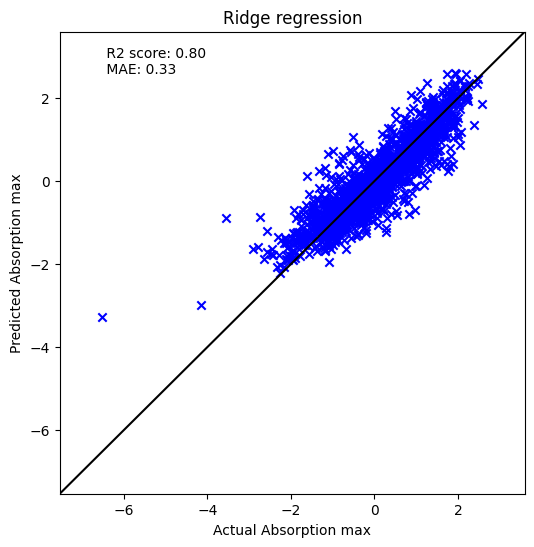

In [15]:
#Plot of RR results

import matplotlib.pyplot as plt

#Limits of plot with offset
offset = 1
min_limit = min(min(y_test_transformed), min(y_pred_ridge)) - offset
max_limit = max(max(y_test_transformed), max(y_pred_ridge)) + offset

plt.figure(figsize=(6, 6))

plt.scatter(y_test_transformed, y_pred_ridge, color='blue', marker = 'x') # Data

plt.plot([min_limit, max_limit], [min_limit, max_limit], color='black')  # Diagonal line


plt.xlim(min_limit, max_limit)  # Set x-axis limits
plt.ylim(min_limit, max_limit)  # Set y-axis limits

plt.title('Ridge regression')
plt.xlabel('Actual Absorption max')
plt.ylabel('Predicted Absorption max')
plt.text(min_limit+offset, max_limit-offset, f" R2 score: {model_eval(y_test_transformed, y_pred_ridge,print_res=False)[0]:.2f}\n MAE: {model_eval(y_test_transformed, y_pred_ridge,print_res=False)[1]:.2f}")
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt

for Model in [Ridge, Lasso]:
    model = Model()
    print('%s: %s' % (Model.__name__, cross_val_score(model, X_train_standardized, y_train_transformed).mean()))

Ridge: 0.7852906770704655
Lasso: -0.00044347511303639565


In [30]:
# Ridge cross validation
from sklearn.linear_model import RidgeCV

r_alphas = np.logspace(0, 5, 10)
rcv = RidgeCV(alphas=r_alphas, cv=3)
rcv.fit(X_train_standardized, y_train_transformed)

y_pred_ridgeCV = rcv.predict(X_test_standardized)
model_eval(y_test_transformed, y_pred_ridgeCV)

R2 score:  0.8040377477087757
MAE:  0.3250572125307233
MSE:  0.19953912889834388


In [36]:
#Without standardization
rcv2 = RidgeCV(alphas=r_alphas, cv=3)
rcv2.fit(X_train, y_train)

y_pred_ridgeCV2 = rcv2.predict(X_test)
model_eval(y_test, y_pred_ridgeCV2)

R2 score:  0.8324214569362963
MAE:  30.62893303133254
MSE:  1839.5277003465426


In [37]:
print('RidgeCV best alpha =', rcv.alpha_, '\n\n')

RidgeCV best alpha = 12.91549665014884 




## Lasso

In [5]:
#Lasso With standardization
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_standardized, y_train_transformed)
y_lasso_pred = lasso_model.predict(X_test_standardized)

model_eval(y_test_transformed, y_lasso_pred)

R2 score:  0.7781750253979922
MAE:  0.34487851186365476
MSE:  0.22587392052527502


In [4]:
lasso_model.n_iter_

116

In [7]:
#Lasso without standardization
lasso_model2 = Lasso(alpha=0.001, max_iter = 200)
lasso_model2.fit(X_train, y_train)
y_lasso_pred2 = lasso_model2.predict(X_test)

model_eval(y_test, y_lasso_pred2)

R2 score:  0.8266899878151224
MAE:  31.102683164800194
MSE:  1902.4426536533772


c:\Users\William Purvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.159e+06, tolerance: 1.743e+04
  model = cd_fast.enet_coordinate_descent(


In [11]:
#LassoCV with standardization
from sklearn.linear_model import LassoCV

y_train_transformed = y_train_transformed.ravel()

lcv = LassoCV(alphas= np.logspace(-5, -2, 10), cv=3, random_state=42, max_iter=10000)
lcv.fit(X_train_standardized, y_train_transformed)

y_lassoCV = lcv.predict(X_test_standardized)
model_eval(y_test_transformed, y_lassoCV)

R2 score:  0.8054461962319317
MAE:  0.3247040424641153
MSE:  0.19810497212517592


In [13]:
print('LassoCV best alpha =', lcv.alpha_, '\n\n')

LassoCV best alpha = 0.00021544346900318823 




In [5]:
y_train = y_train.ravel()

lcv2 = LassoCV(alphas= np.logspace(-5, -2, 10), cv=3, random_state=42, max_iter=10000)
lcv2.fit(X_train, y_train)

y_lassoCV2 = lcv2.predict(X_test)
model_eval(y_test, y_lassoCV2)

c:\Users\William Purvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16314.138461748138, tolerance: 11966.638247137038
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\William Purvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44882.90046411753, tolerance: 11966.638247137038
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\William Purvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204515.7168984227, tolerance: 11966.638247137038
  model = cd_fast.ene

KeyboardInterrupt: 

## ElasticNet

In [23]:
#Elastic Net with standardization
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=1, max_iter=100)
enet.fit(X_train_standardized, y_train_transformed)

y_enet = enet.predict(X_test_standardized)

model_eval(y_test_transformed, y_enet)

R2 score:  -3.678254176864293e-05
MAE:  0.8160525766159841
MSE:  1.0182903397034655


In [24]:
#Elastic Net without standardization

enet2 = ElasticNet(alpha=1, max_iter=100)
enet2.fit(X_train, y_train)

y_enet2 = enet2.predict(X_test)

model_eval(y_test, y_enet2)

R2 score:  0.5113972493274463
MAE:  54.93615758903855
MSE:  5363.444972701584


In [45]:
#Cross validation of Elastic Net
from sklearn.linear_model import ElasticNetCV

enetCV = ElasticNetCV(max_iter=500)
enetCV.fit(X_train_standardized, y_train_transformed)

y_enetCV = enetCV.predict(X_test_standardized)


model_eval(y_test_transformed, y_enetCV)

R2 score:  0.8019556003176707
MAE:  0.32644982982072684
MSE:  0.20165928148794376


In [47]:
print('Elastic Net best alpha when L1 ratio = 0.2: 0.0016087772068907537')
print('Elastic Net best alpha when L1 ratio = 0.5: 0.0006435108827563009')
print('Elastic Net best alpha when L1 ratio = 0.7: 0.0004596506305402153')

Elastic Net best alpha when L1 ratio = 0.2: 0.0016087772068907537
Elastic Net best alpha when L1 ratio = 0.5: 0.0006435108827563009
Elastic Net best alpha when L1 ratio = 0.7: 0.0004596506305402153


## MLP

In [55]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=(100,), max_iter = 200, random_state=23)
MLP.fit(X_train_standardized, y_train_transformed)

y_MLP_pred = MLP.predict(X_test_standardized)
model_eval(y_test_transformed, y_MLP_pred)

R2 score:  0.9393014870447186
MAE:  0.14636923210583386
MSE:  0.06180643597891572
